In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Set up
import sys

sys.path.append("/home/dchen/BA_CH_EN/")

# Basics
import tensorflow as tf
import xarray as xr
import numpy as np
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.DRN.DRN_load_preds import *
from src.models.DRN.DRN_load_preds_dummy_10 import *
from src.models.EMOS_local.EMOS_local_load_preds import *  # Load EMOS_global_preds
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_preds import *  # Load EMOS_global_preds
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores

<IPython.core.display.Javascript object>

### 1. Load Predictions

In [3]:
# EMOS_global
EMOS_global_t2m_preds = EMOS_global_load_preds("t2m")
EMOS_global_ws10_preds = EMOS_global_load_preds("ws10")

# EMOS_global
EMOS_local_t2m_preds = EMOS_local_load_preds("t2m")
EMOS_local_ws10_preds = EMOS_local_load_preds("ws10")

# EMOS_global
DRN_t2m_preds = DRN_load_preds_dummy_10("t2m")[slice(0, 31, 15)]
DRN_ws10_preds = DRN_load_preds_dummy_10("ws10")[slice(0, 31, 15)]

<IPython.core.display.Javascript object>

### 2. Load Matching Ground Truth Values

In [4]:
t2m_ground_truth = ldpd.load_data_all_test_proc_denorm()[2].t2m_test_truth
ws10_ground_truth = ldpd.load_data_all_test_proc_denorm()[5].ws10_test_truth

<IPython.core.display.Javascript object>

### 3. PIT Histogram

In [9]:
def plot_pit_histogram(pred_array, truth_array, num_bins=100, ax=None):
    """
    Plots the Probability Integral Transform (PIT) Histogram for the predictions and truth values.
    
    Args:
        pred_array (np.array): Predictions array of shape (357, 120, 130, 2) with last dimension holding mean and standard deviation.
        truth_array (np.array): Ground truth array of shape (357, 120, 130).
        num_bins (int): Number of bins for the histogram. Defaults to 100.
        ax (matplotlib.axes.Axes): Axis on which to plot the histogram. If None, a new axis is created. Defaults to None.
    
    Returns:
        None. Plots the PIT Histogram.
    """

    # If no axis is provided, create a new one
    if ax is None:
        fig, ax = plt.subplots()

    # Reshape the arrays to have shape (-1, 2) and (-1) for predictions and truth respectively
    pred_array_reshaped = pred_array.reshape(-1, 2)
    truth_array_reshaped = truth_array.reshape(-1)

    # Get mean and standard deviation predictions
    mean_pred = np.abs(pred_array_reshaped[:, 0])
    std_pred = np.abs(
        pred_array_reshaped[:, 1]
    )  # take the absolute of the standard deviation predictions

    # Compute PIT values
    PIT_values = norm.cdf(truth_array_reshaped, loc=mean_pred, scale=std_pred)

    # Flatten the PIT_values array
    PIT_values_flattened = PIT_values.flatten()

    # Plot the PIT Histogram on the given axis
    ax.hist(
        PIT_values_flattened, bins=num_bins, density=True, alpha=0.75, edgecolor="black"
    )
    ax.set_title("PIT Histogram")
    ax.set_xlabel("PIT Value")
    ax.set_ylabel("Density")

    # Show the plot if it's on a new axis
    if ax is None:
        plt.show()


def plot_pit_histogram_all(pred_arrays, truth_arrays, num_bins=30, ax=None, title=None):
    fig, axs = plt.subplots(3, 1, figsize=(20, 20))
    for count, lead in enumerate([1, 16, 31]):
        plot_pit_histogram(
            pred_arrays[lead - 1],
            truth_arrays.isel(lead_time=lead).values,
            num_bins=num_bins,
            ax=axs[count],
        )
        axs[count].set_title(f"PIT histogram: Lead time: {lead - 1}")
        if title != None:
            fig.suptitle(title, fontsize=16)

<IPython.core.display.Javascript object>

In [6]:
def compute_pit_values(pred_array, truth_array):
    """
    Compute the PIT values for the predictions and truth values.
    
    Args:
        pred_array (np.array): Predictions array of shape (n_samples, 2) with last dimension holding mean and standard deviation.
        truth_array (np.array): Ground truth array of shape (n_samples).
    
    Returns:
        PIT_values (np.array): Array of PIT values.
    """

    # Get mean and standard deviation predictions
    mean_pred = np.abs(pred_array[:, 0])
    std_pred = np.abs(
        pred_array[:, 1]
    )  # take the absolute of the standard deviation predictions

    # Compute PIT values
    PIT_values = norm.cdf(truth_array, loc=mean_pred, scale=std_pred)

    return PIT_values


def plot_pit_histogram_ls(pit_values, num_bins=100, ax=None):
    """
    Plots the Probability Integral Transform (PIT) Histogram for the provided PIT values.
    
    Args:
        pit_values (np.array): Array of PIT values.
        num_bins (int): Number of bins for the histogram. Defaults to 100.
        ax (matplotlib.axes.Axes): Axis on which to plot the histogram. If None, a new axis is created. Defaults to None.
    
    Returns:
        None. Plots the PIT Histogram.
    """

    # If no axis is provided, create a new one
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the PIT Histogram on the given axis
    ax.hist(pit_values, bins=num_bins, density=True, alpha=0.75, edgecolor="black")
    ax.set_title("PIT Histogram")
    ax.set_xlabel("PIT Value")
    ax.set_ylabel("Density")

    # Show the plot if it's on a new axis
    if ax is None:
        plt.show()


def plot_pit_histogram_land_sea(
    pred_arrays, truth_arrays, land_sea, num_bins=30, ax=None, title=None
):
    fig, axs = plt.subplots(3, 1, figsize=(20, 20))

    land_sea_mask_dummy = np.load(
        "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
    )
    land_sea_mask = xr.DataArray(
        land_sea_mask_dummy,
        dims=["lat", "lon"],
        coords={"lat": t2m_test_1.lat, "lon": t2m_test_1.lon},
    )

    if land_sea == 1:
        mask_bool = land_sea_mask_dummy.astype(bool)
    elif land_sea == 0:
        mask_bool = land_sea_mask_dummy.astype(bool)
        mask_bool = np.invert(mask_bool)
    for count, lead in enumerate([1, 16, 31]):
        # extend mask to have the same number of dimensions as arr
        mask_broadcasted = np.broadcast_to(
            mask_bool[np.newaxis, :, :, np.newaxis], pred_arrays[count].shape
        )
        # Use numpy.where to replace masked values with NaN
        preds_subs = np.where(mask_broadcasted, pred_arrays[count], np.nan)
        preds_subs = preds_subs.reshape(-1, 2)
        preds_subs = preds_subs[~np.isnan(preds_subs).any(axis=1)]

        truth_arrays_lead = truth_arrays.isel(lead_time=lead)
        truth_arrays_lead = truth_arrays_lead.where(land_sea_mask == land_sea)
        truth_arrays_lead = truth_arrays_lead.values.flatten()
        truth_arrays_lead = truth_arrays_lead[~np.isnan(truth_arrays_lead)]

        pit_values = compute_pit_values(preds_subs, truth_arrays_lead)
        plot_pit_histogram_ls(pit_values, num_bins=num_bins, ax=axs[count])
        axs[count].set_title(f"PIT histogram: Lead time: {lead - 1}")
        if title != None:
            fig.suptitle(title, fontsize=16)

<IPython.core.display.Javascript object>

#### 3.1 t2m EMOS_global - all

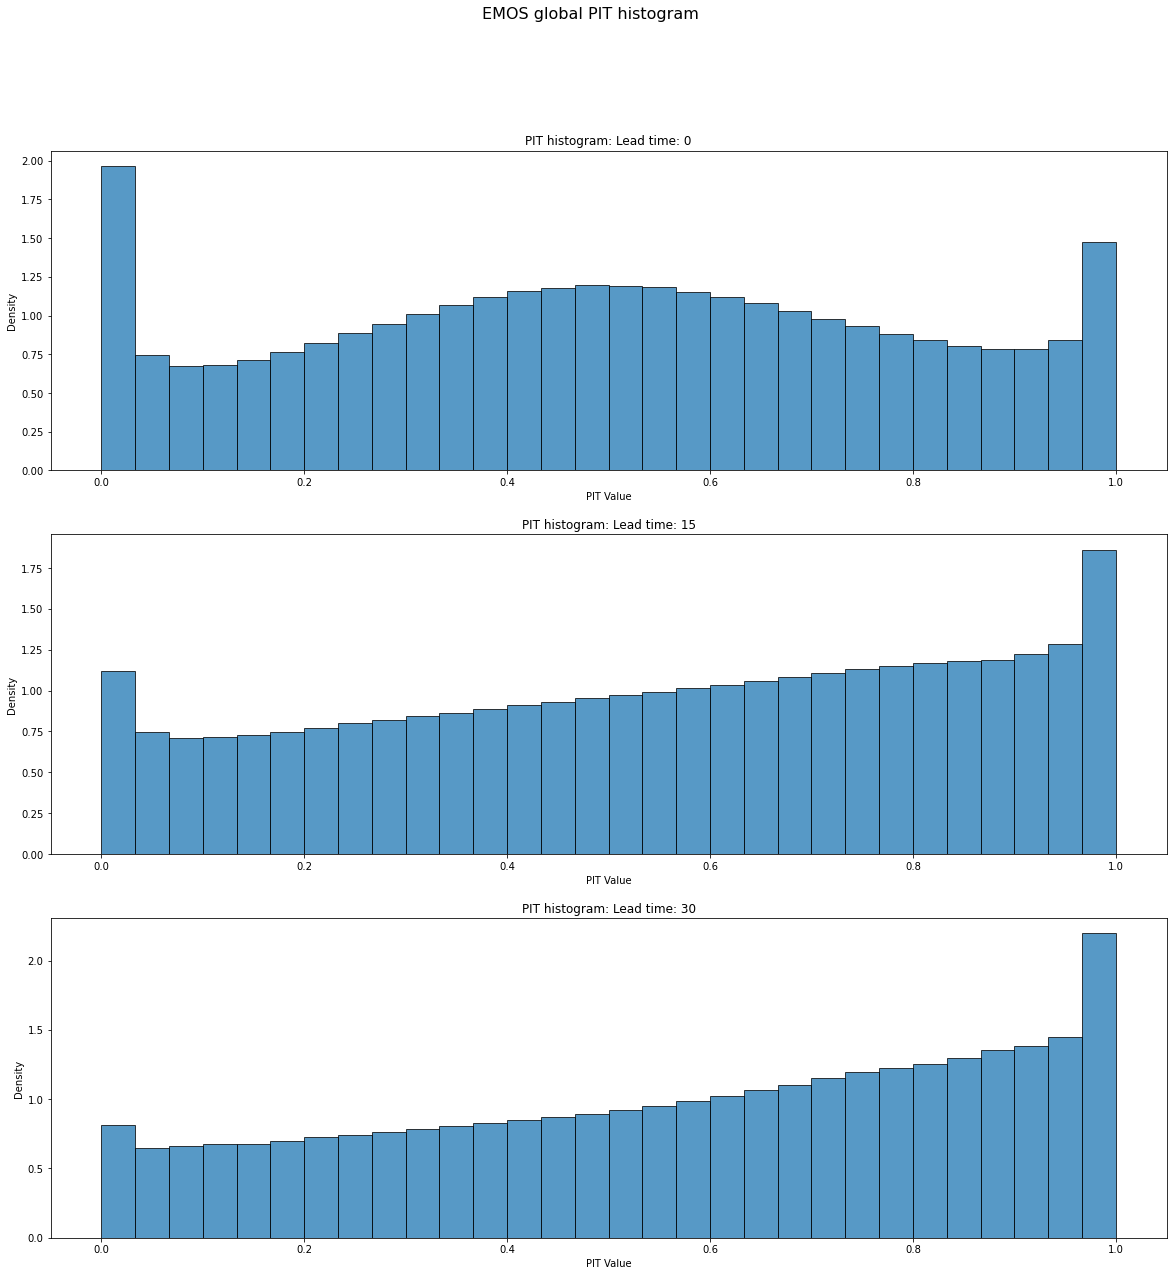

<IPython.core.display.Javascript object>

In [10]:
plot_pit_histogram_all(
    EMOS_global_t2m_preds,
    t2m_ground_truth,
    num_bins=30,
    title="EMOS global PIT histogram",
)

#### 3.2 t2m - EMOS_global land

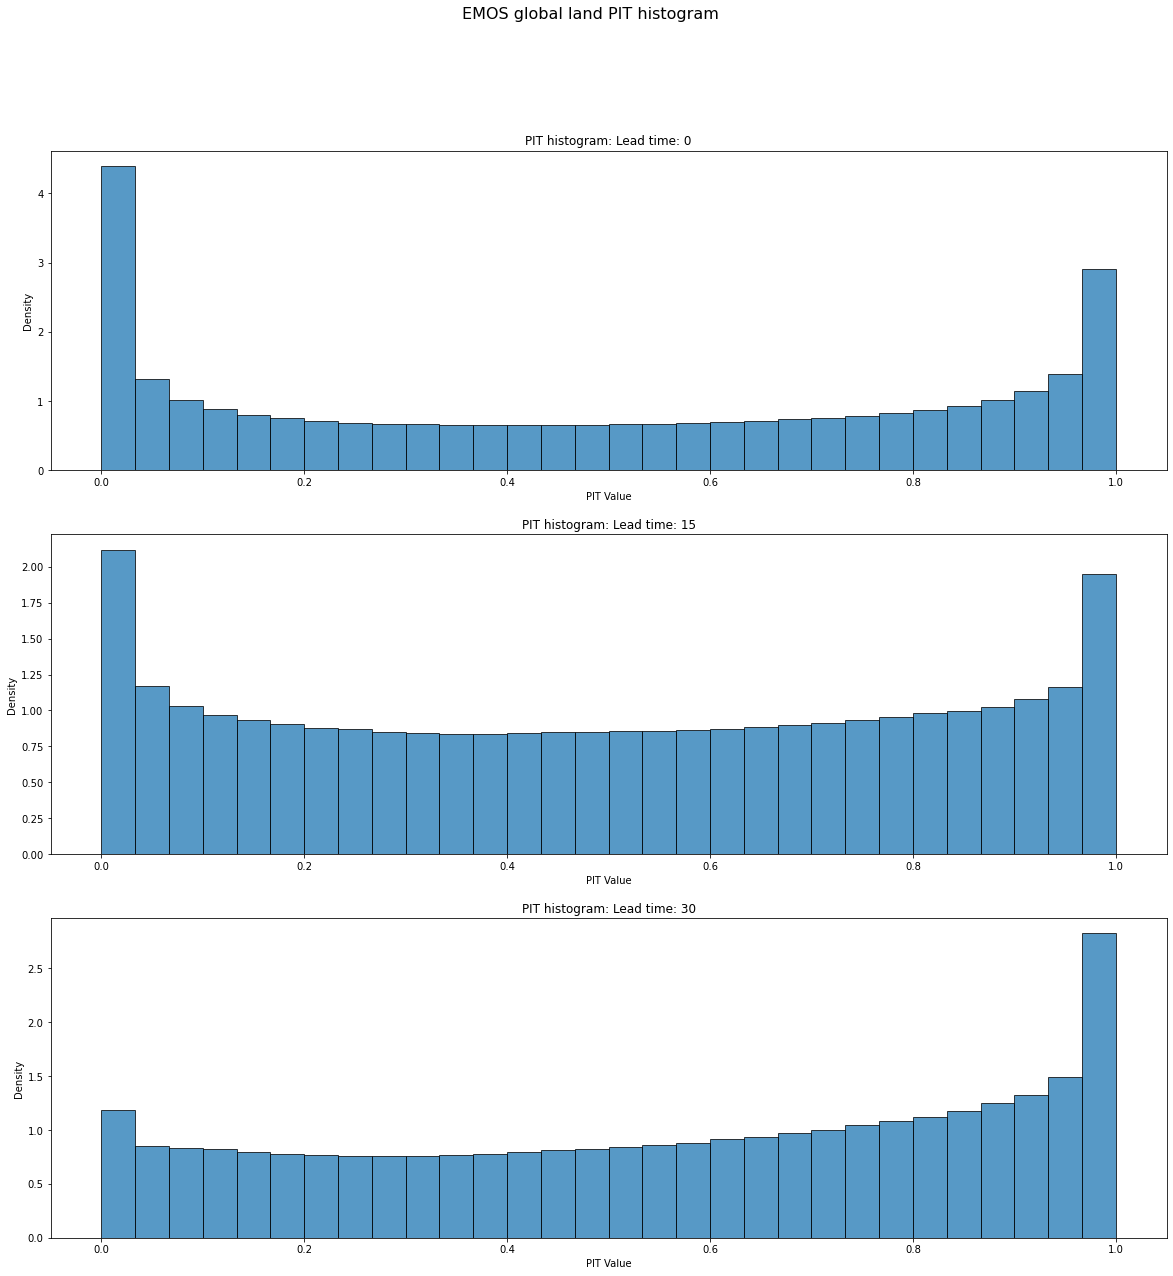

<IPython.core.display.Javascript object>

In [182]:
plot_pit_histogram_land_sea(
    EMOS_global_t2m_preds,
    t2m_ground_truth,
    1,
    num_bins=30,
    title="EMOS global land PIT histogram",
)

####  3.3 t2m - EMOS_global sea

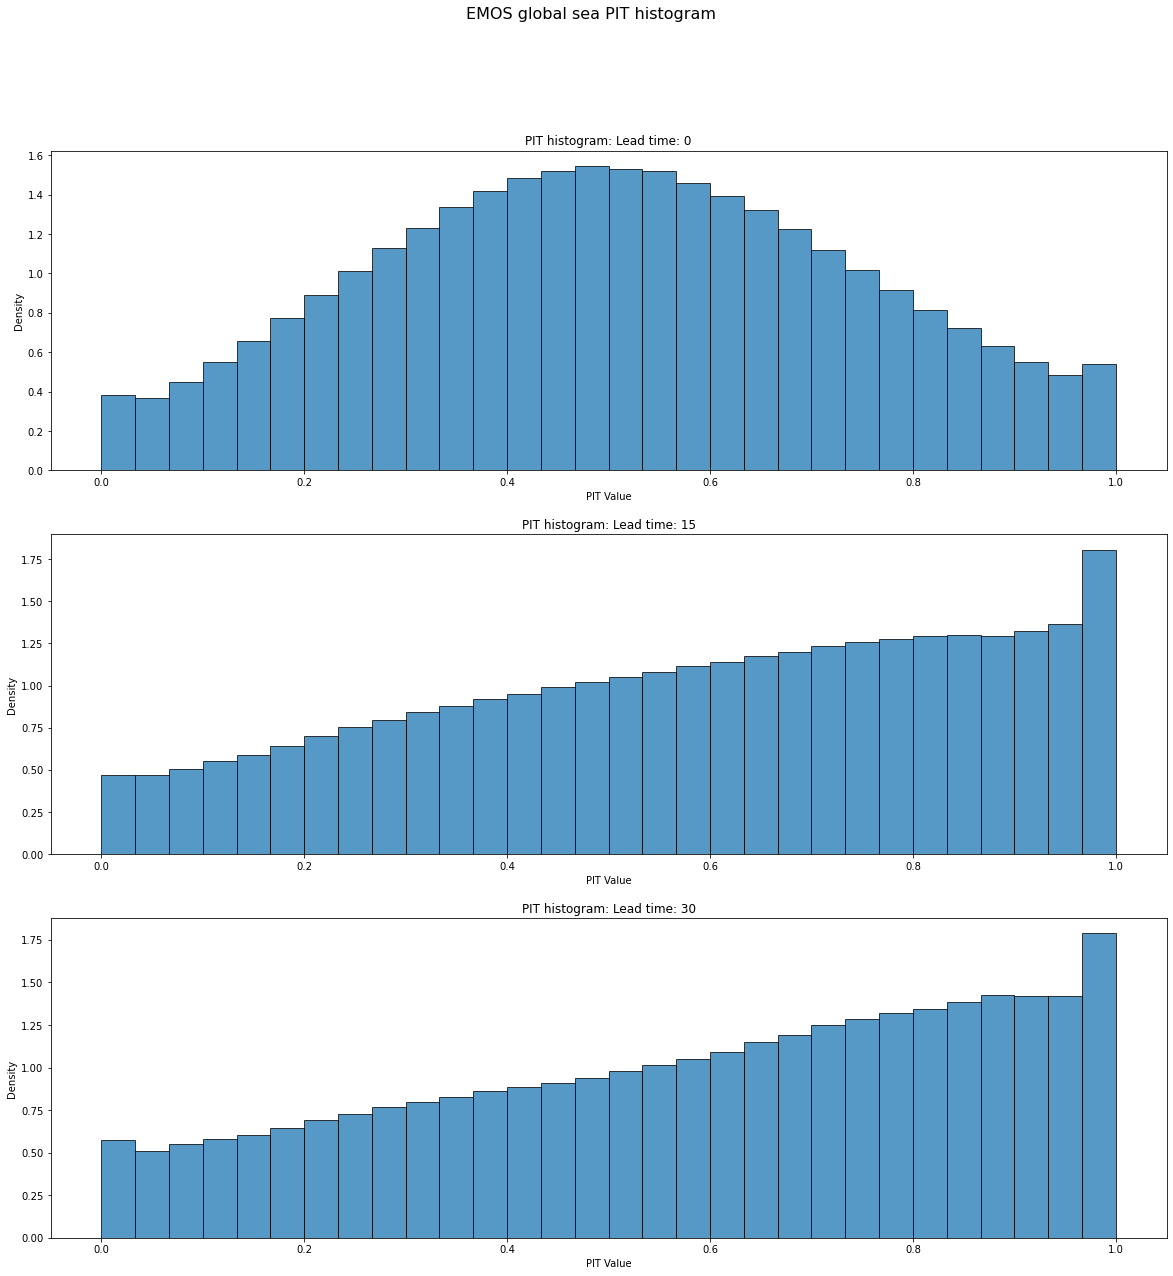

<IPython.core.display.Javascript object>

In [185]:
plot_pit_histogram_land_sea(
    EMOS_global_t2m_preds,
    t2m_ground_truth,
    0,
    num_bins=30,
    title="EMOS global sea PIT histogram",
)

#### 3.4 t2m EMOS_local all

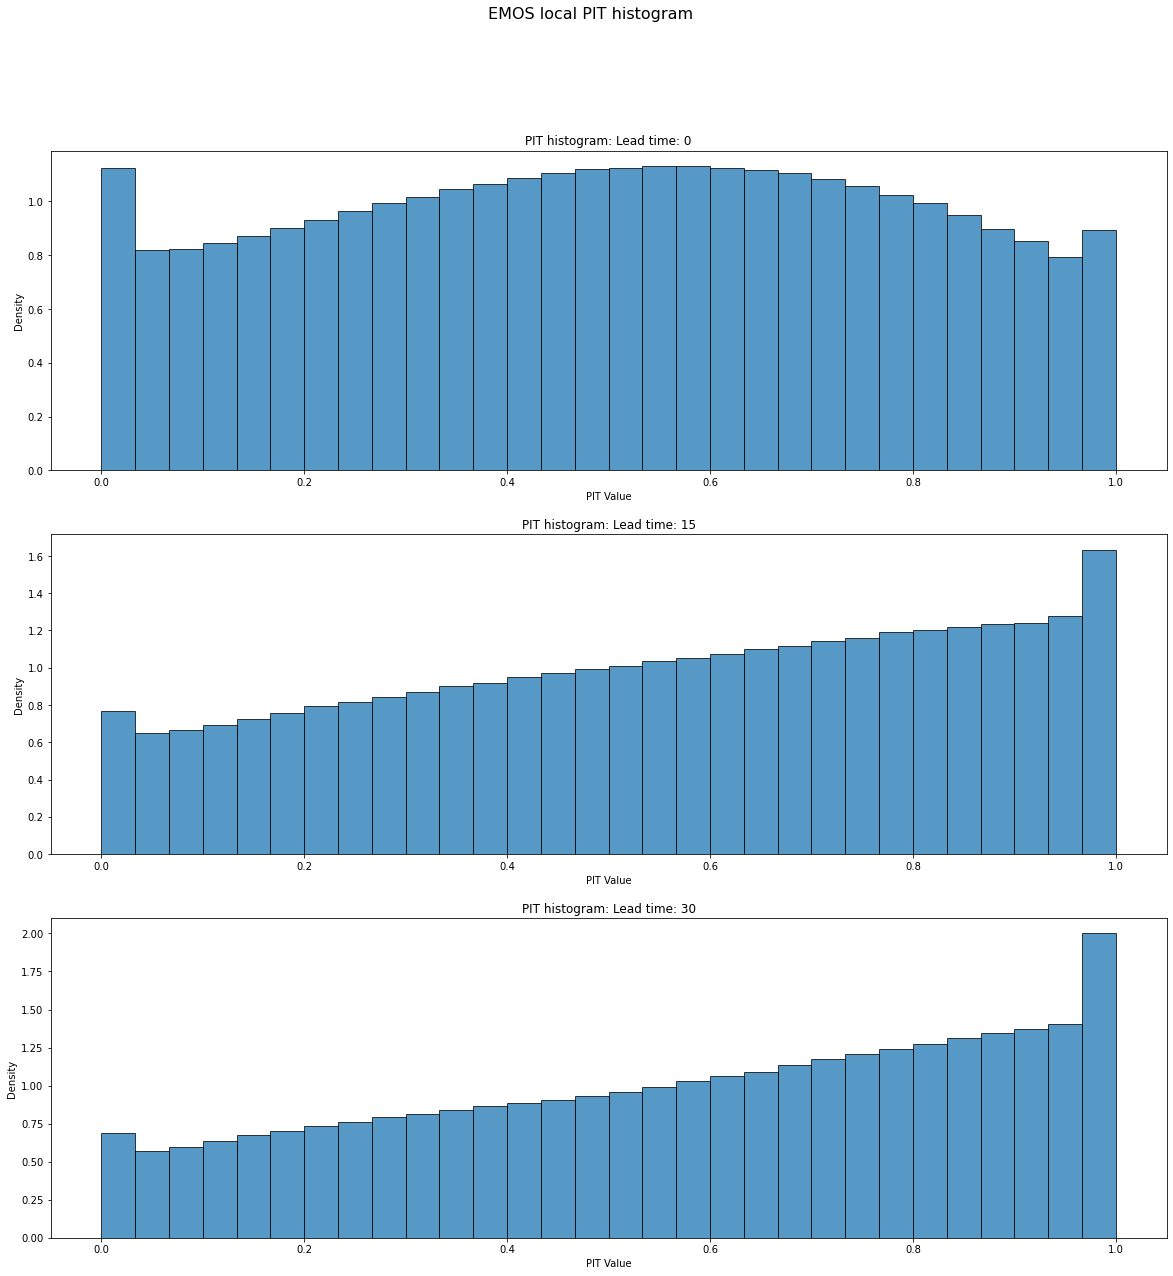

<IPython.core.display.Javascript object>

In [193]:
plot_pit_histogram_all(
    EMOS_local_t2m_preds,
    t2m_ground_truth,
    num_bins=30,
    title="EMOS local PIT histogram",
)

#### 3.5 t2m - EMOS_local land

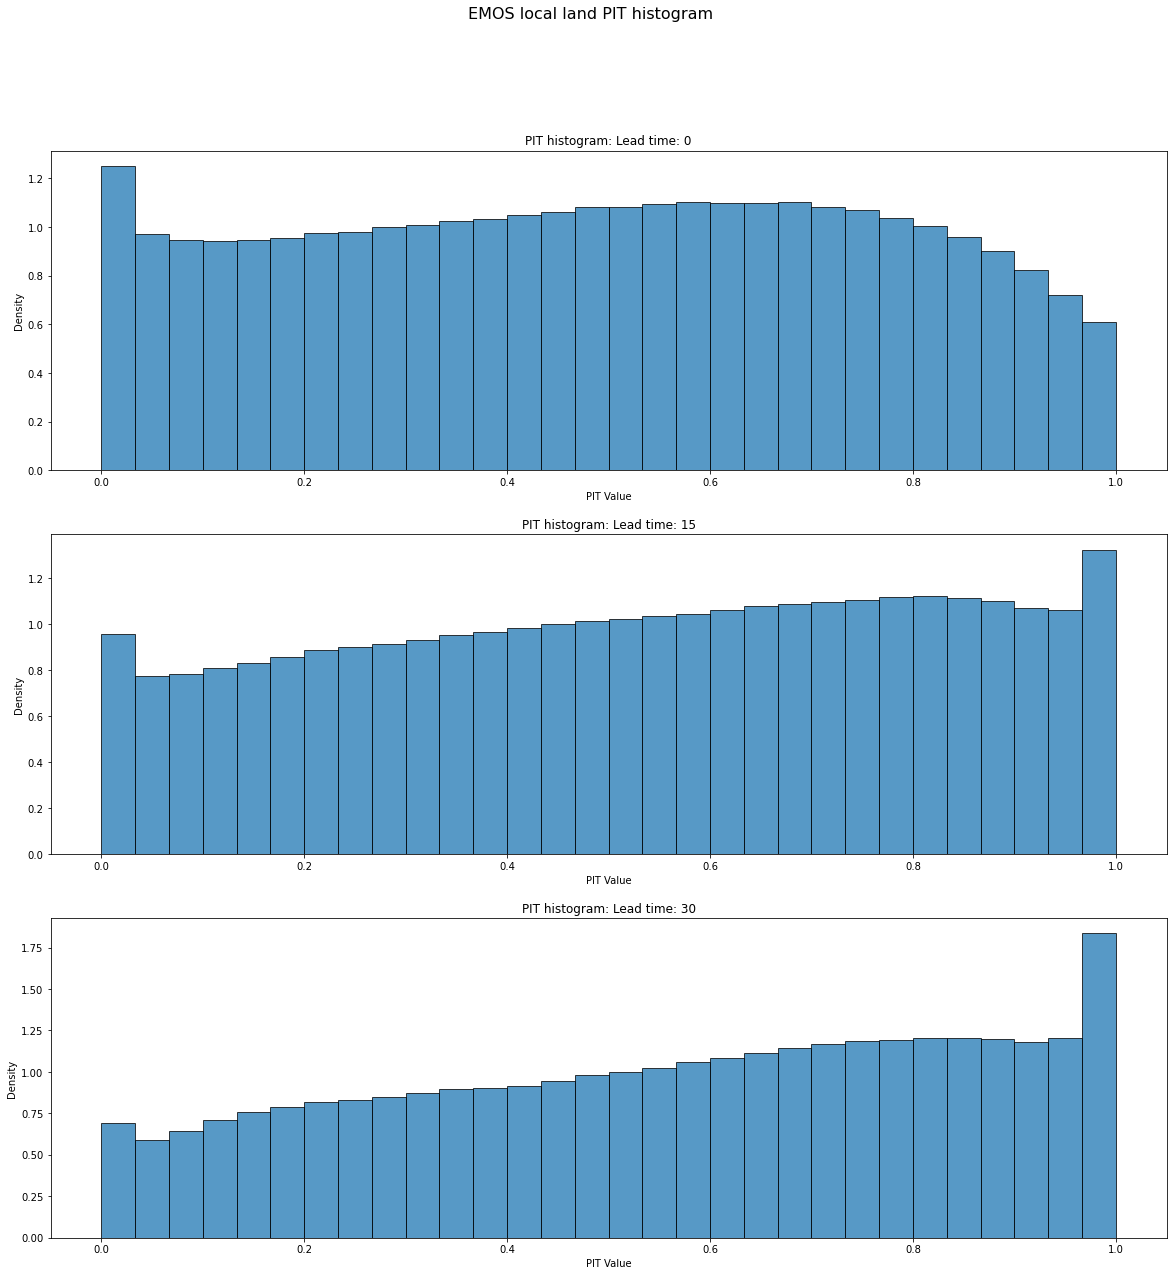

<IPython.core.display.Javascript object>

In [187]:
plot_pit_histogram_land_sea(
    EMOS_local_t2m_preds,
    t2m_ground_truth,
    1,
    num_bins=30,
    title="EMOS local land PIT histogram",
)

####  3.6 t2m - EMOS_local sea

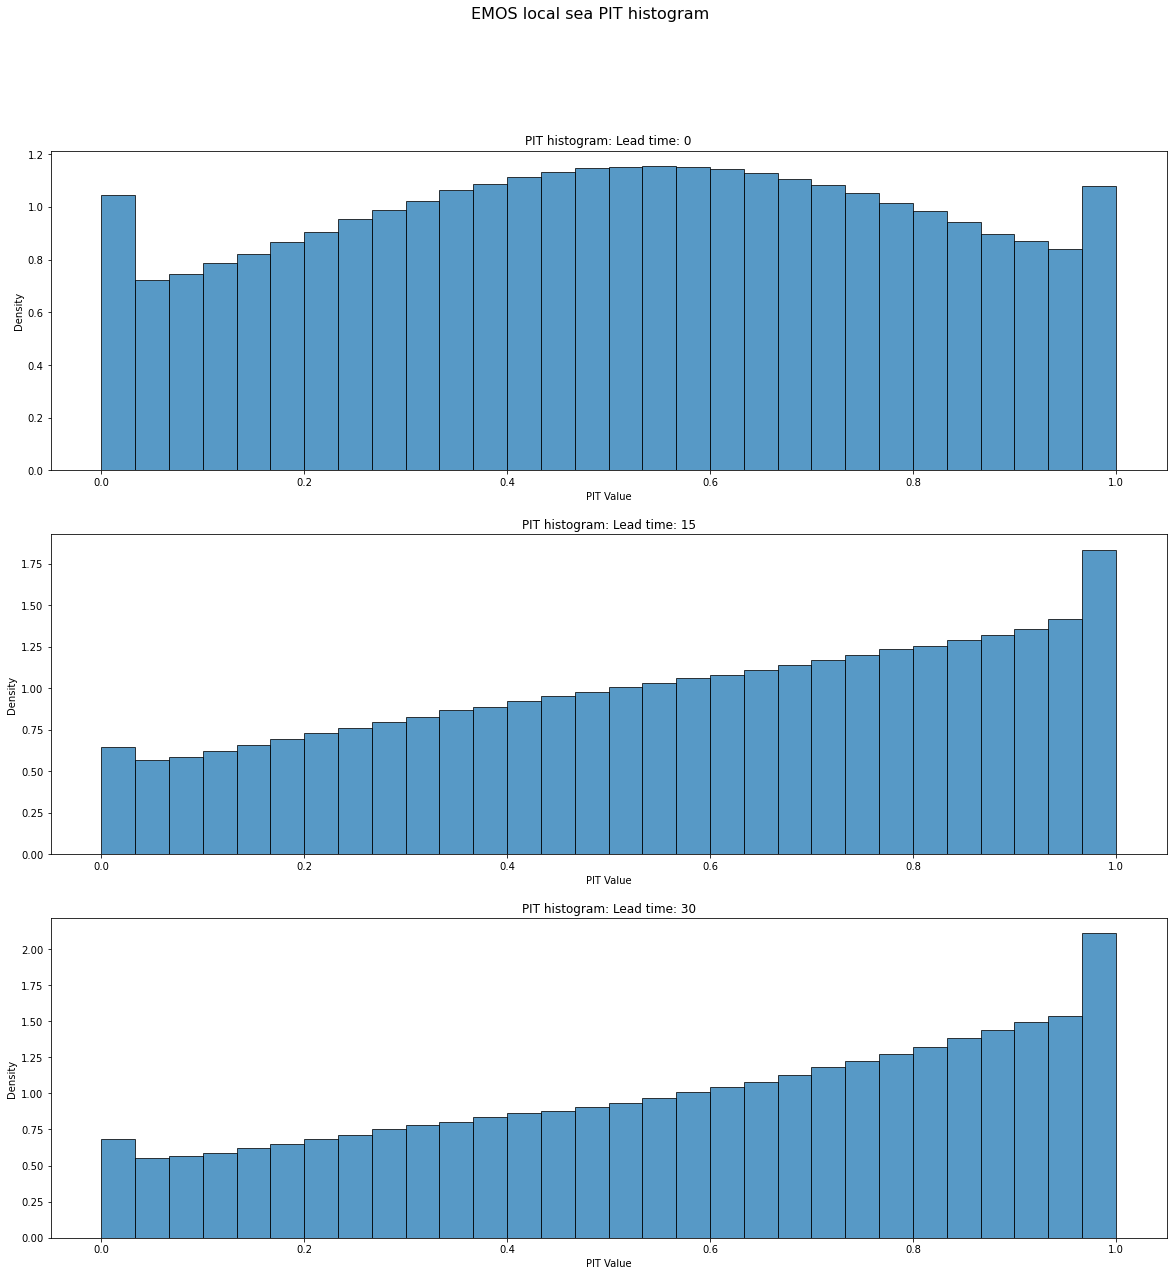

<IPython.core.display.Javascript object>

In [189]:
plot_pit_histogram_land_sea(
    EMOS_local_t2m_preds,
    t2m_ground_truth,
    0,
    num_bins=30,
    title="EMOS local sea PIT histogram",
)

#### 3.7 t2m - DRN_all

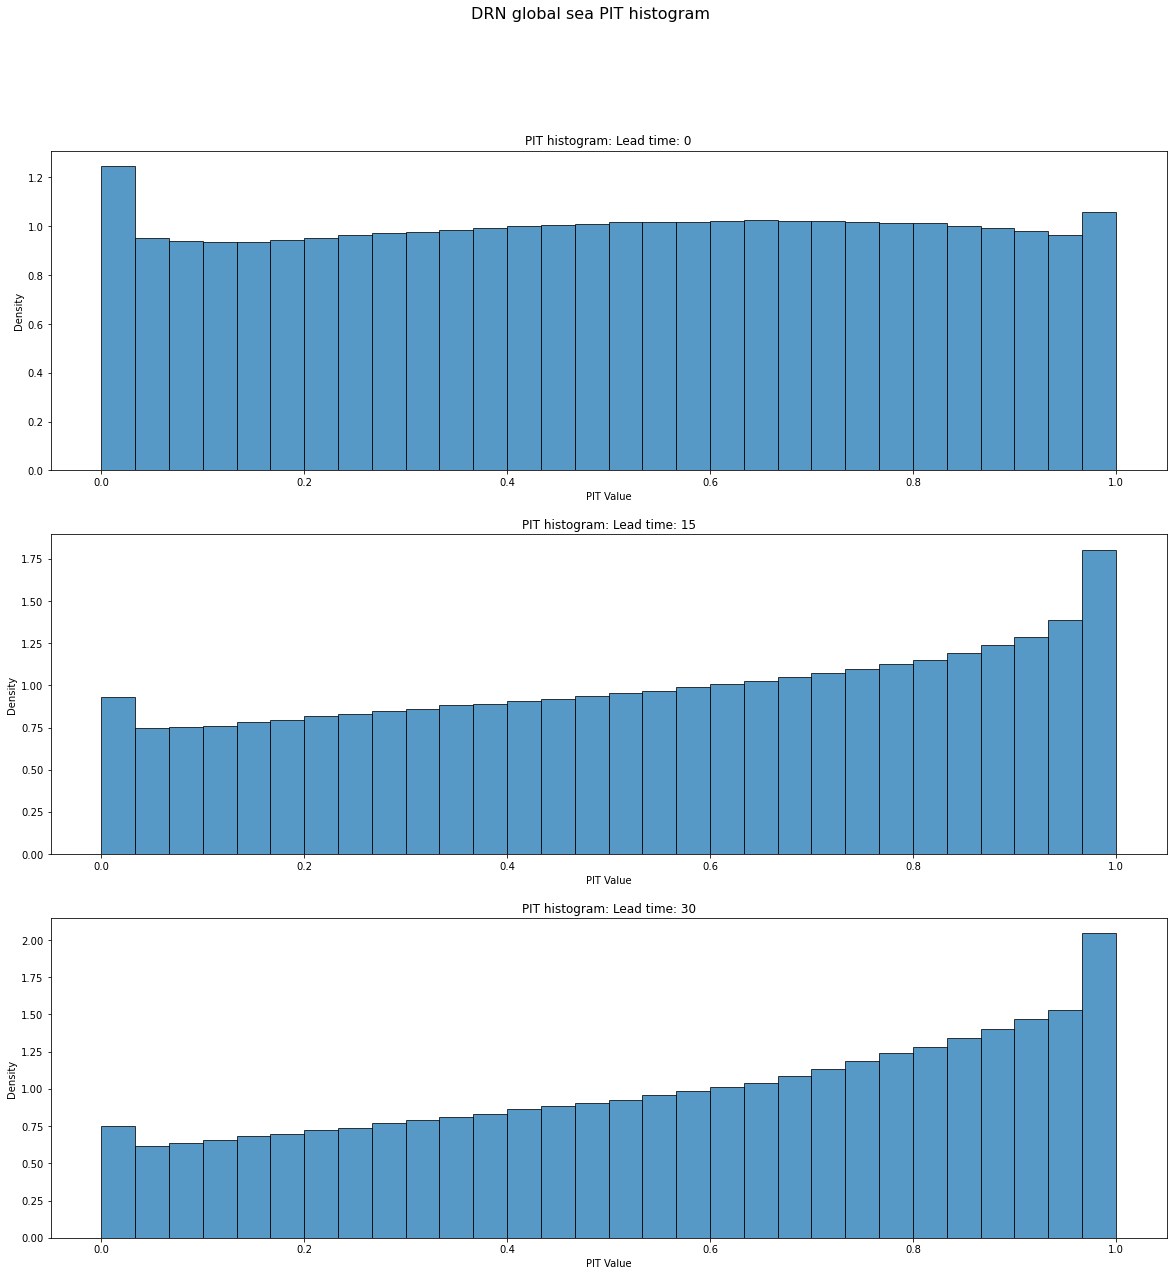

<IPython.core.display.Javascript object>

In [194]:
plot_pit_histogram_all(
    DRN_t2m_preds, t2m_ground_truth, num_bins=30, title="DRN global sea PIT histogram"
)

#### 3.8 t2m - DRN land

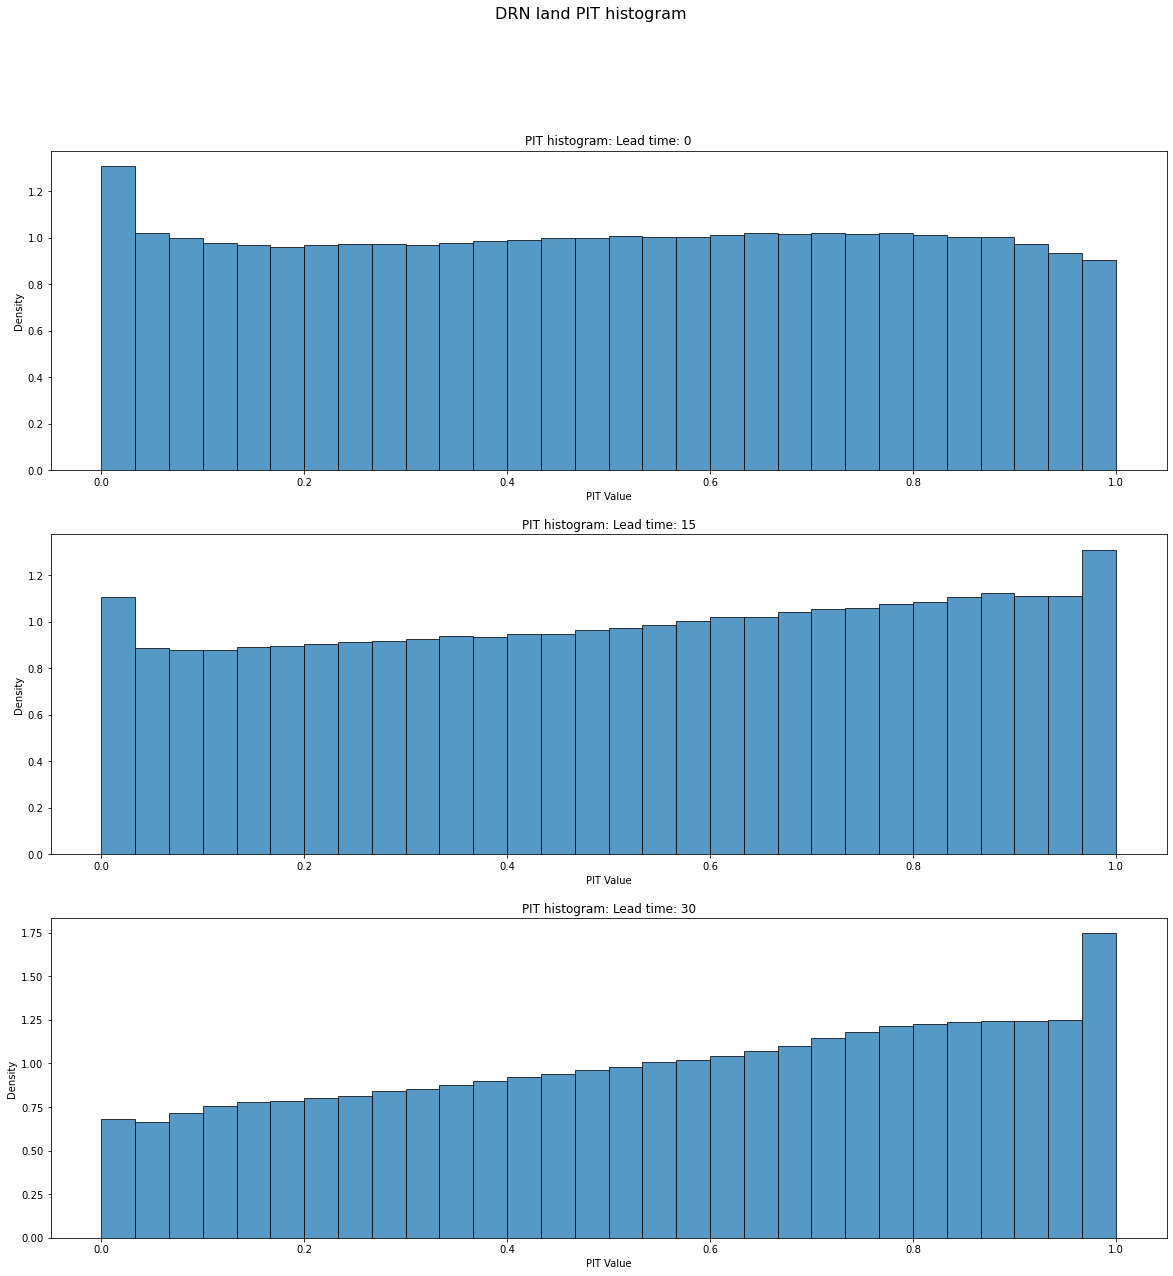

<IPython.core.display.Javascript object>

In [191]:
plot_pit_histogram_land_sea(
    DRN_t2m_preds, t2m_ground_truth, 1, num_bins=30, title="DRN land PIT histogram",
)

####  3.9 t2m - DRN sea

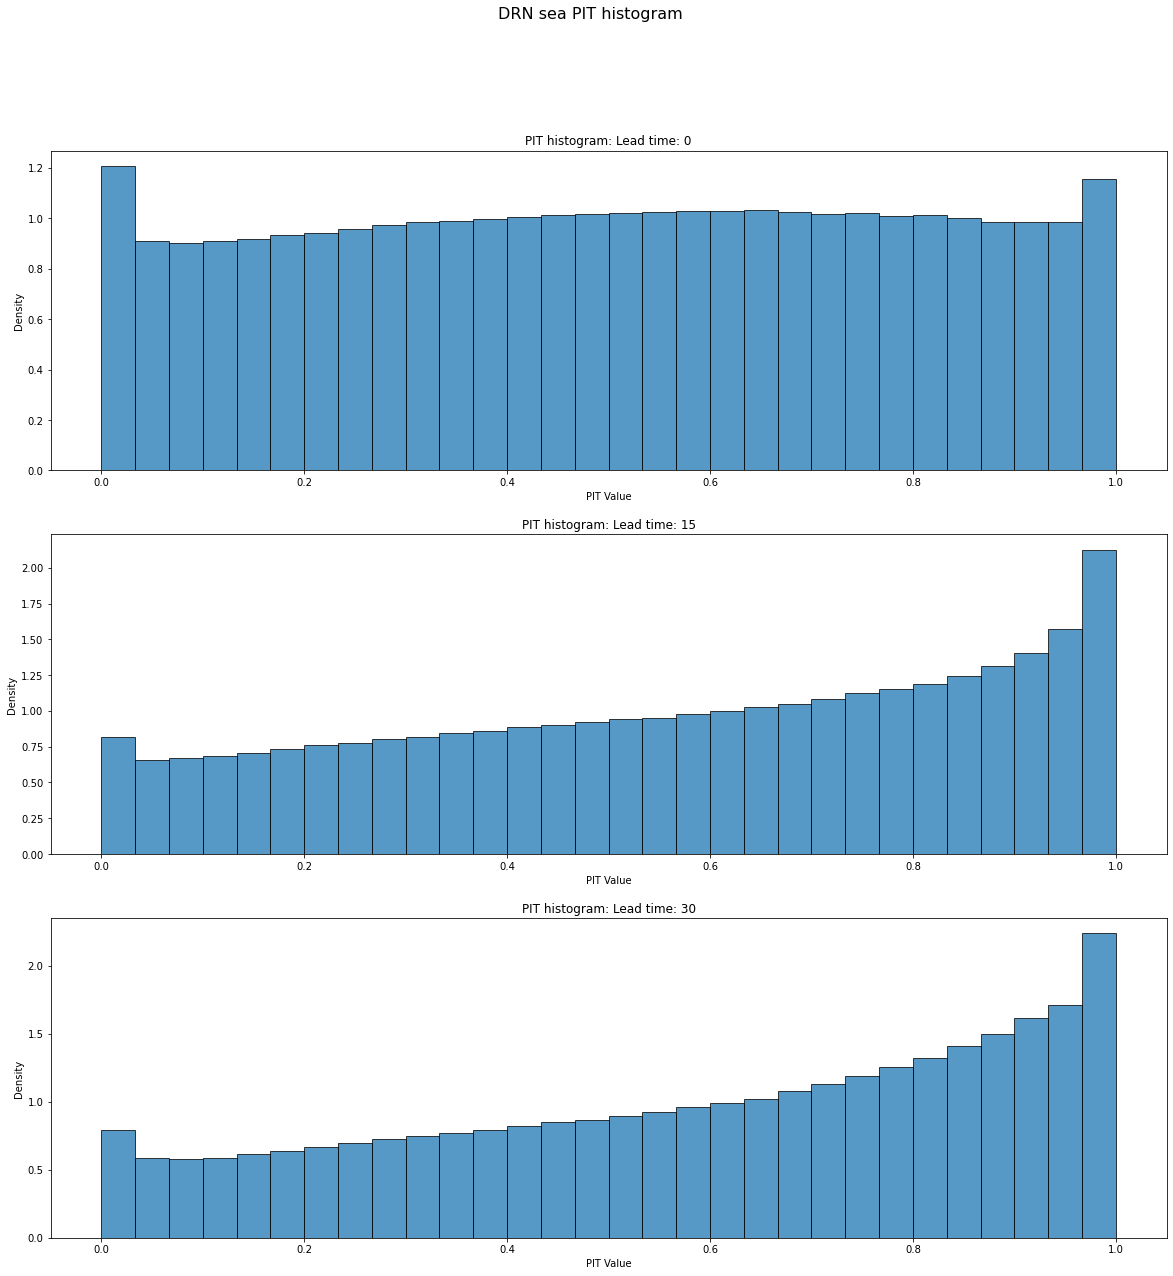

<IPython.core.display.Javascript object>

In [192]:
plot_pit_histogram_land_sea(
    DRN_t2m_preds, t2m_ground_truth, 0, num_bins=30, title="DRN sea PIT histogram",
)

#### 4.1 ws10 EMOS_global - all

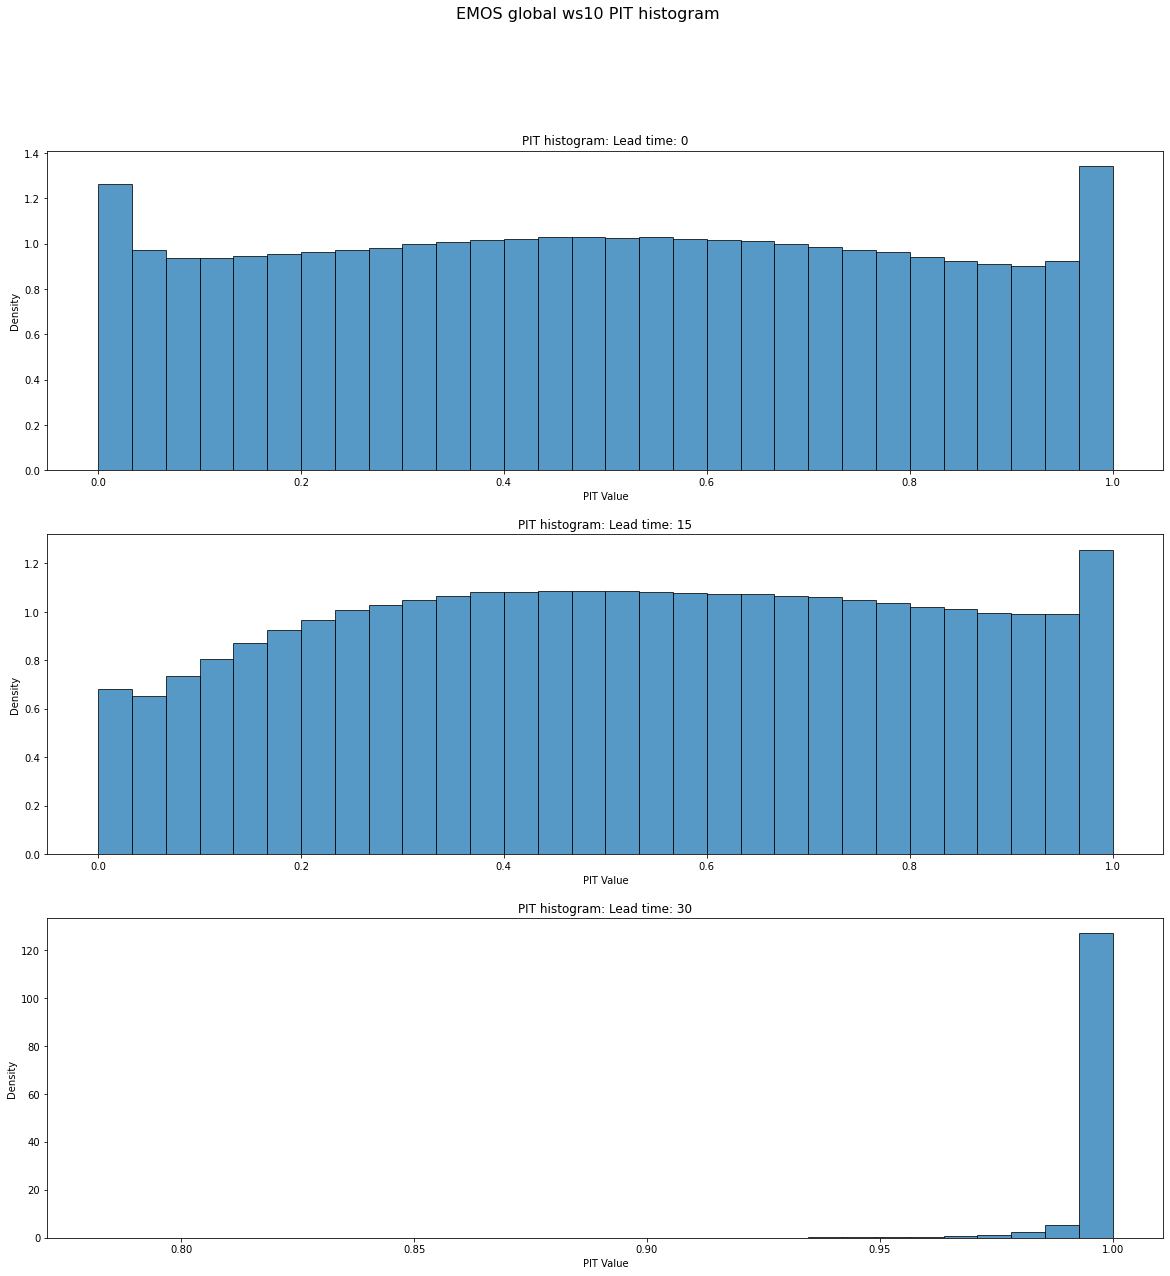

<IPython.core.display.Javascript object>

In [12]:
plot_pit_histogram_all(
    EMOS_global_ws10_preds,
    ws10_ground_truth,
    num_bins=30,
    title="EMOS global ws10 PIT histogram",
)

#### 3.2 ws10 - EMOS_global land

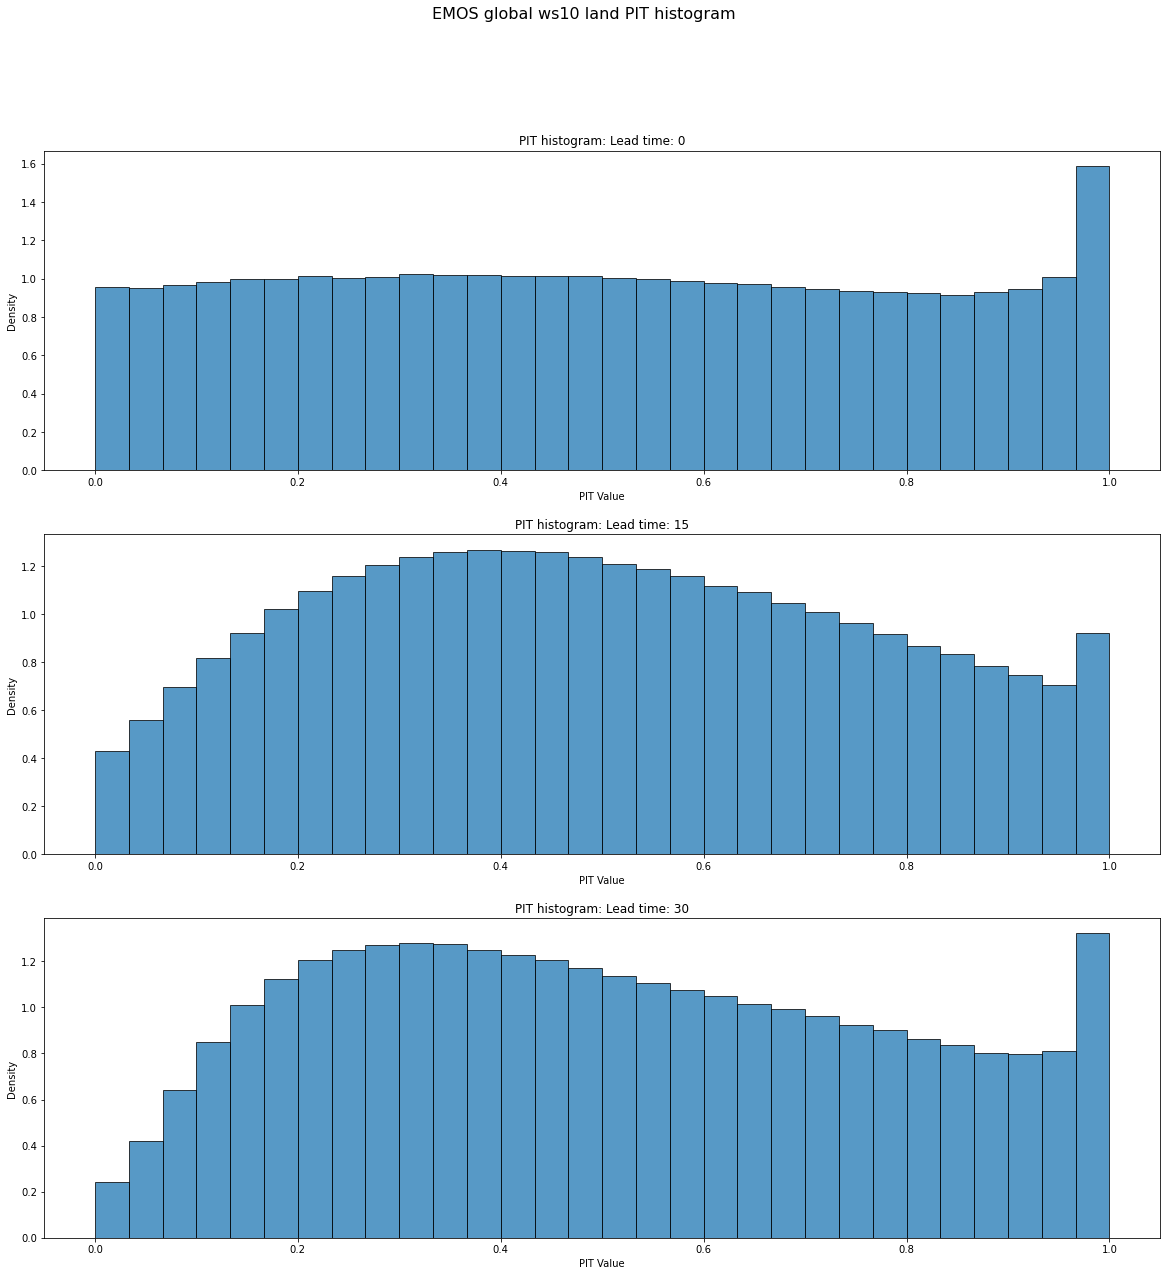

<IPython.core.display.Javascript object>

In [197]:
plot_pit_histogram_land_sea(
    EMOS_global_ws10_preds,
    ws10_ground_truth,
    1,
    num_bins=30,
    title="EMOS global ws10 land PIT histogram",
)

####  3.3 ws10 - EMOS_global sea

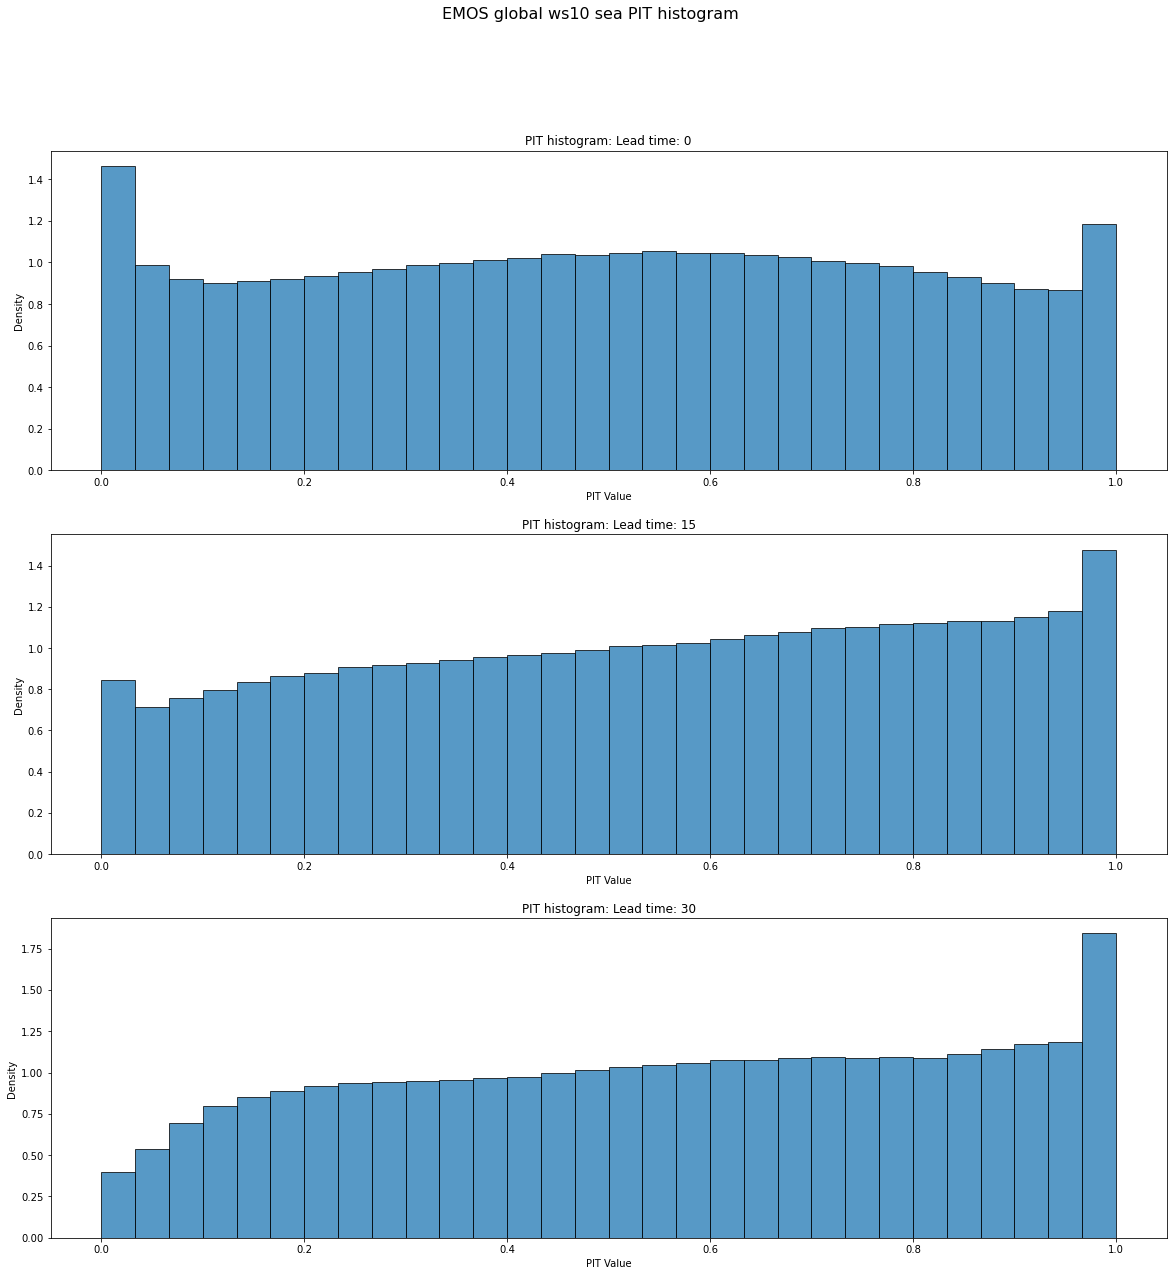

<IPython.core.display.Javascript object>

In [198]:
plot_pit_histogram_land_sea(
    EMOS_global_ws10_preds,
    ws10_ground_truth,
    0,
    num_bins=30,
    title="EMOS global ws10 sea PIT histogram",
)

#### 3.4 ws10 EMOS_local all

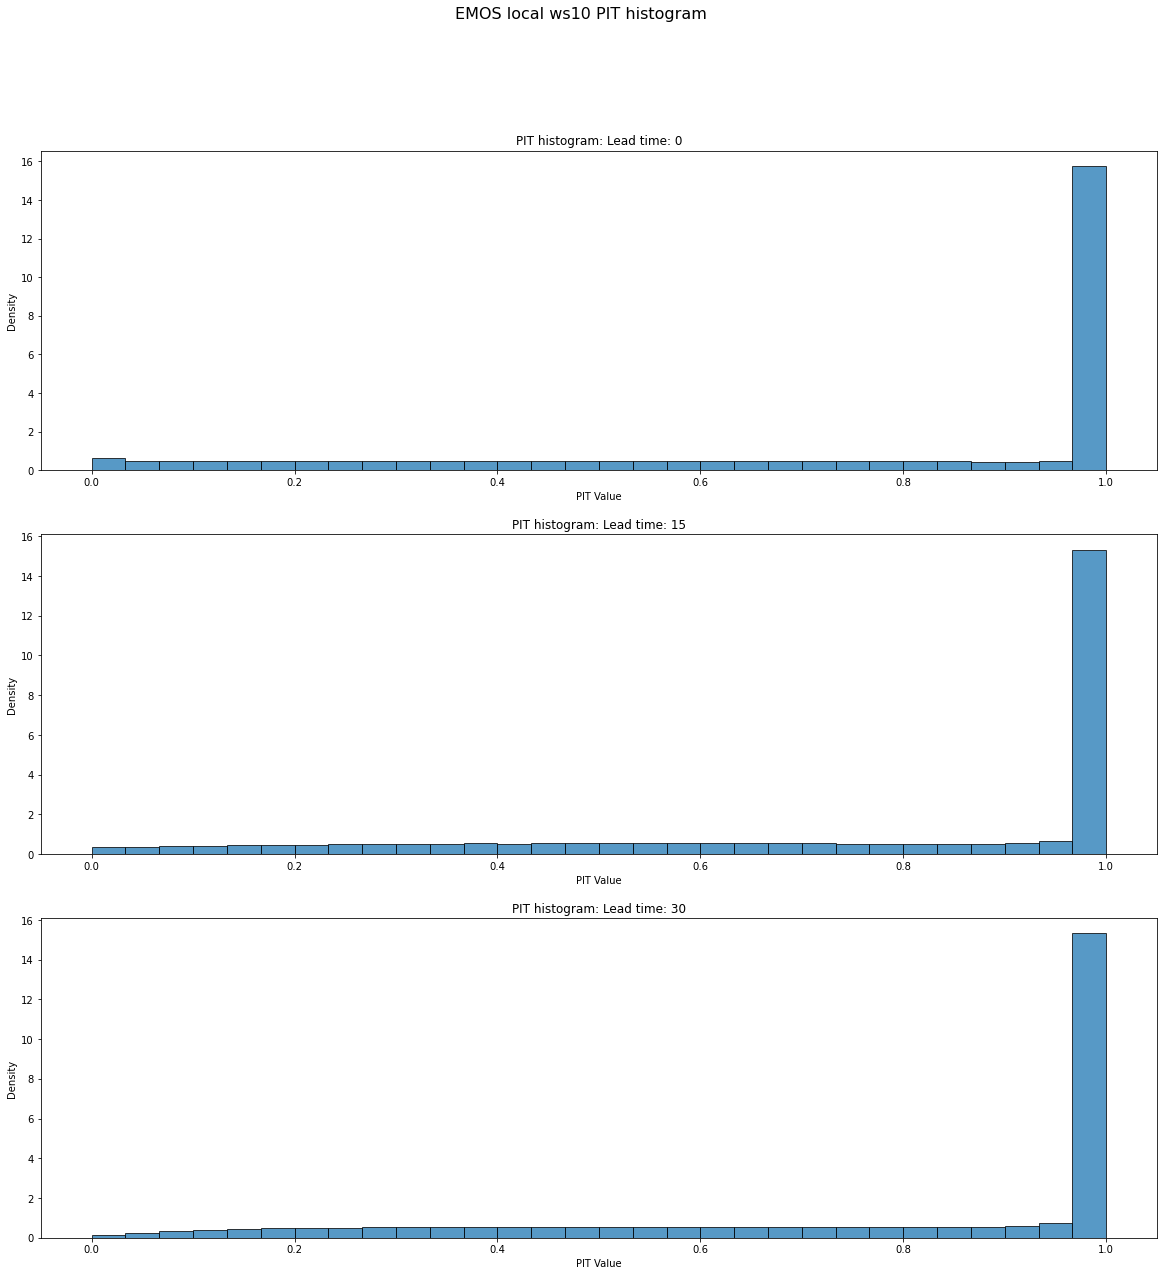

<IPython.core.display.Javascript object>

In [11]:
plot_pit_histogram_all(
    EMOS_local_ws10_preds,
    ws10_ground_truth,
    num_bins=30,
    title="EMOS local ws10 PIT histogram",
)

#### 3.5 ws10 - EMOS_local land

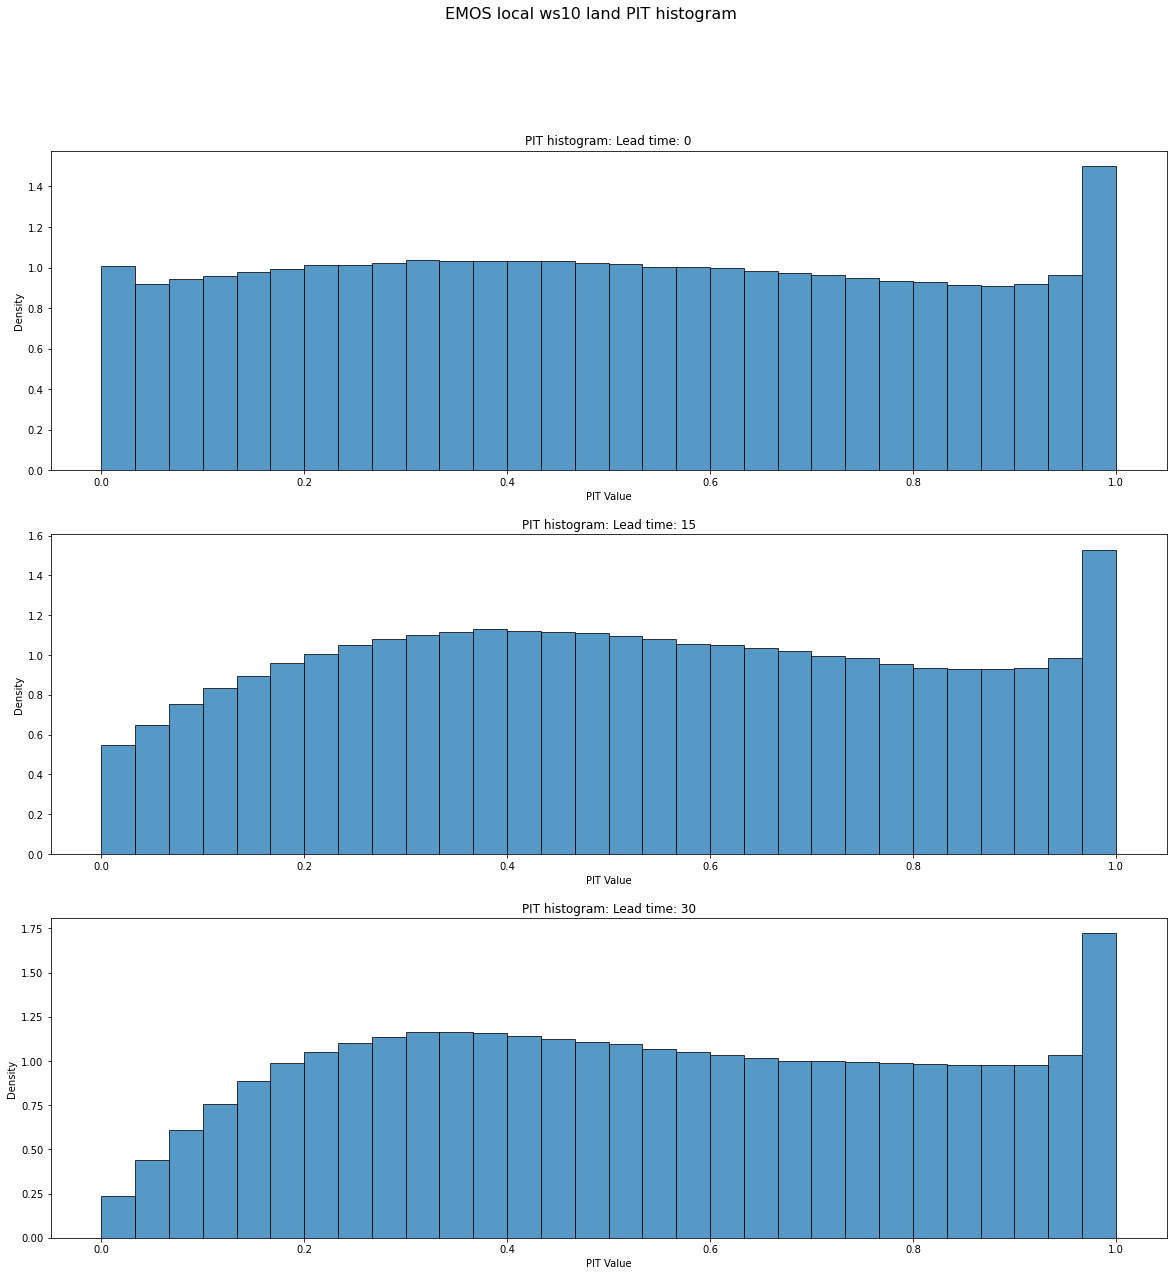

<IPython.core.display.Javascript object>

In [200]:
plot_pit_histogram_land_sea(
    EMOS_local_ws10_preds,
    ws10_ground_truth,
    1,
    num_bins=30,
    title="EMOS local ws10 land PIT histogram",
)

####  3.6 ws10 - EMOS_local sea

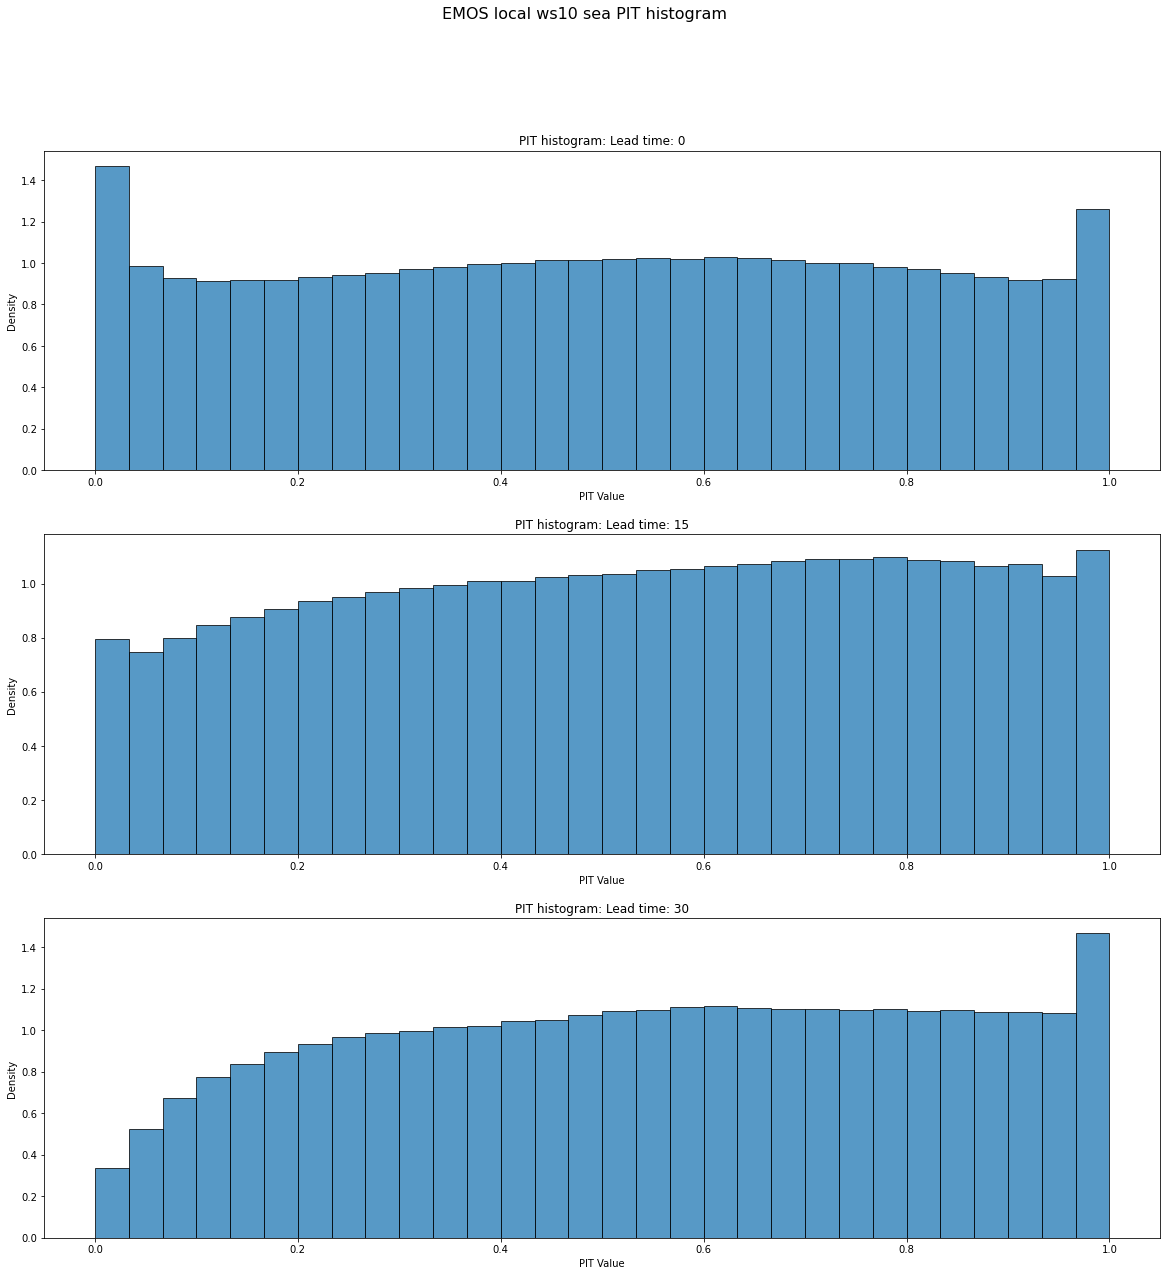

<IPython.core.display.Javascript object>

In [201]:
plot_pit_histogram_land_sea(
    EMOS_local_ws10_preds,
    ws10_ground_truth,
    0,
    num_bins=30,
    title="EMOS local ws10 sea PIT histogram",
)

#### 3.7 ws10 - DRN_all

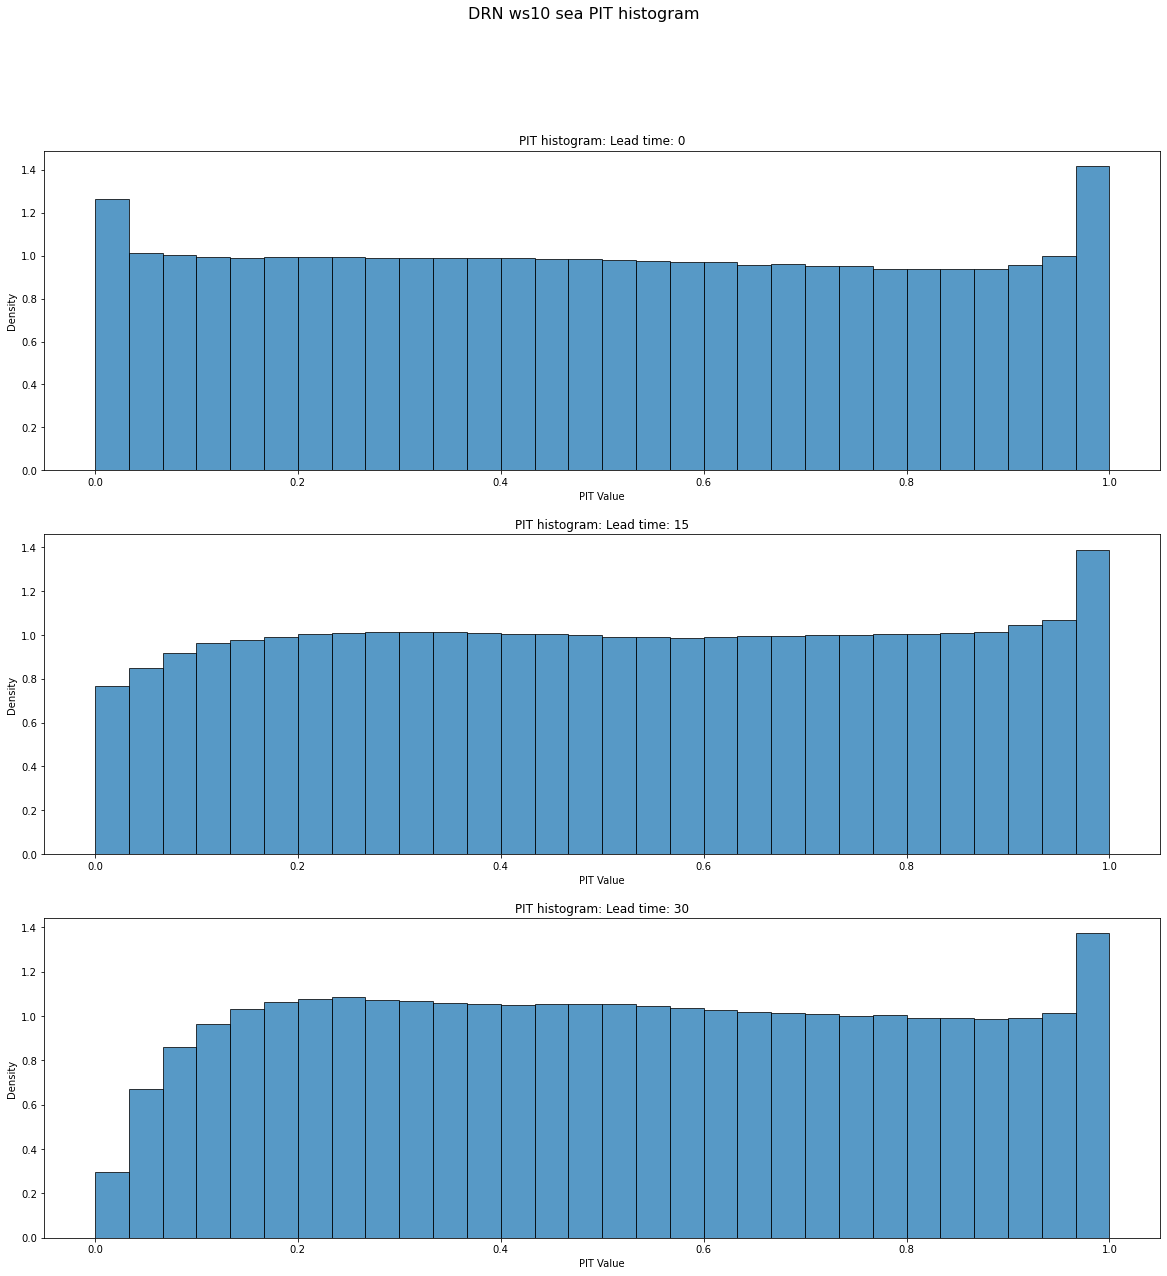

<IPython.core.display.Javascript object>

In [202]:
plot_pit_histogram_all(
    DRN_ws10_preds, ws10_ground_truth, num_bins=30, title="DRN ws10 sea PIT histogram"
)

#### 3.8 ws10 - DRN land

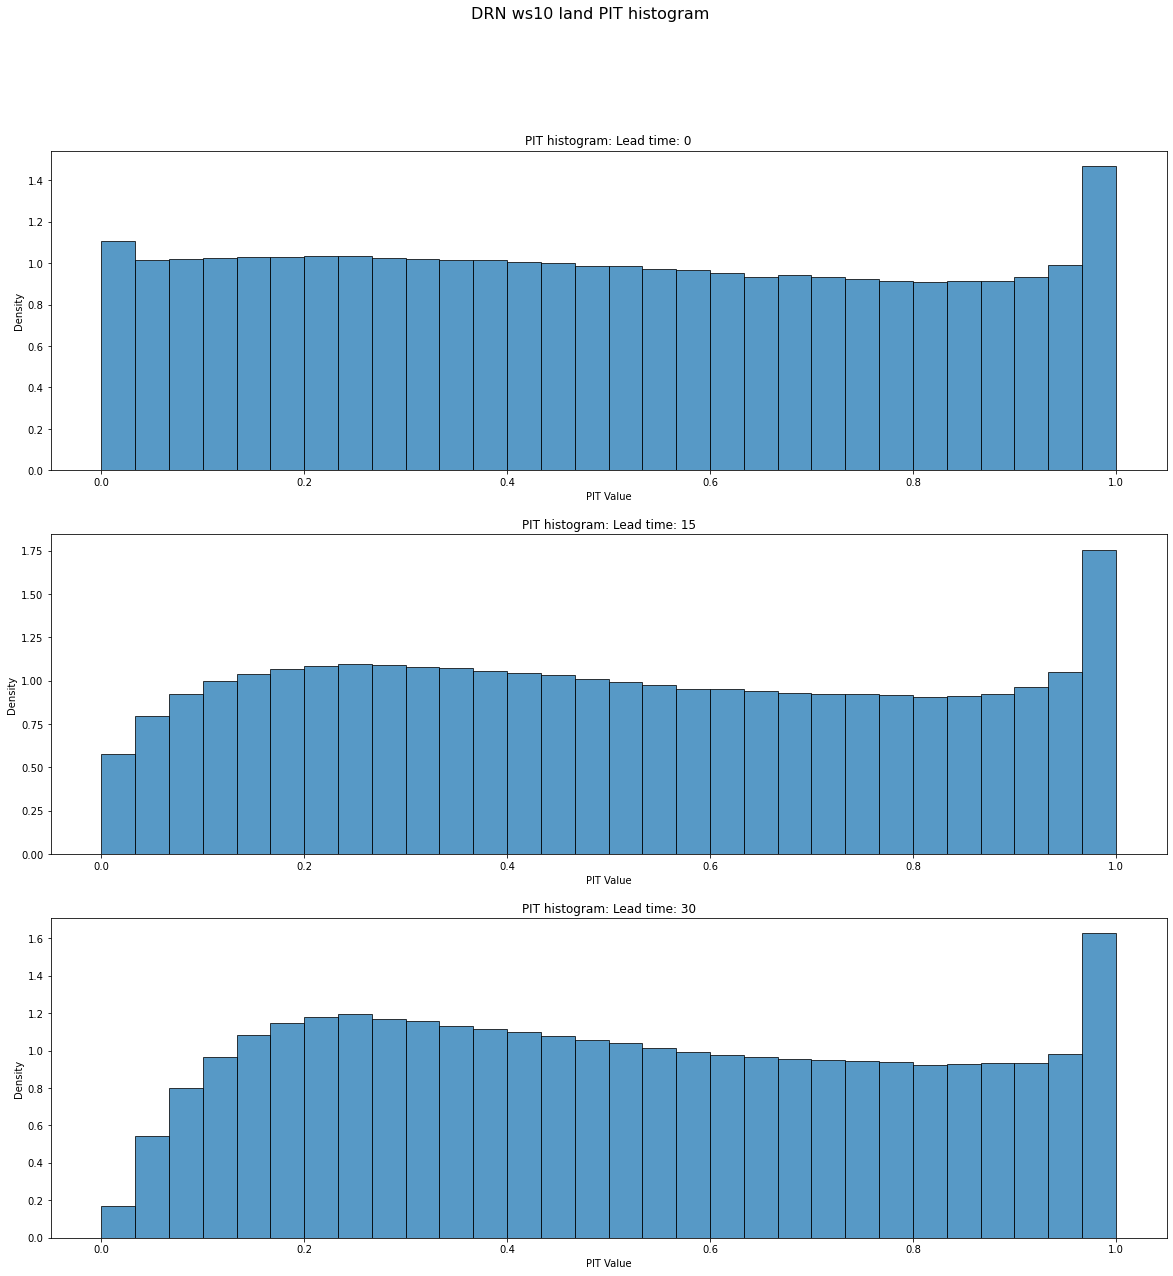

<IPython.core.display.Javascript object>

In [203]:
plot_pit_histogram_land_sea(
    DRN_ws10_preds,
    ws10_ground_truth,
    1,
    num_bins=30,
    title="DRN ws10 land PIT histogram",
)

####  3.9 ws10 - DRN sea

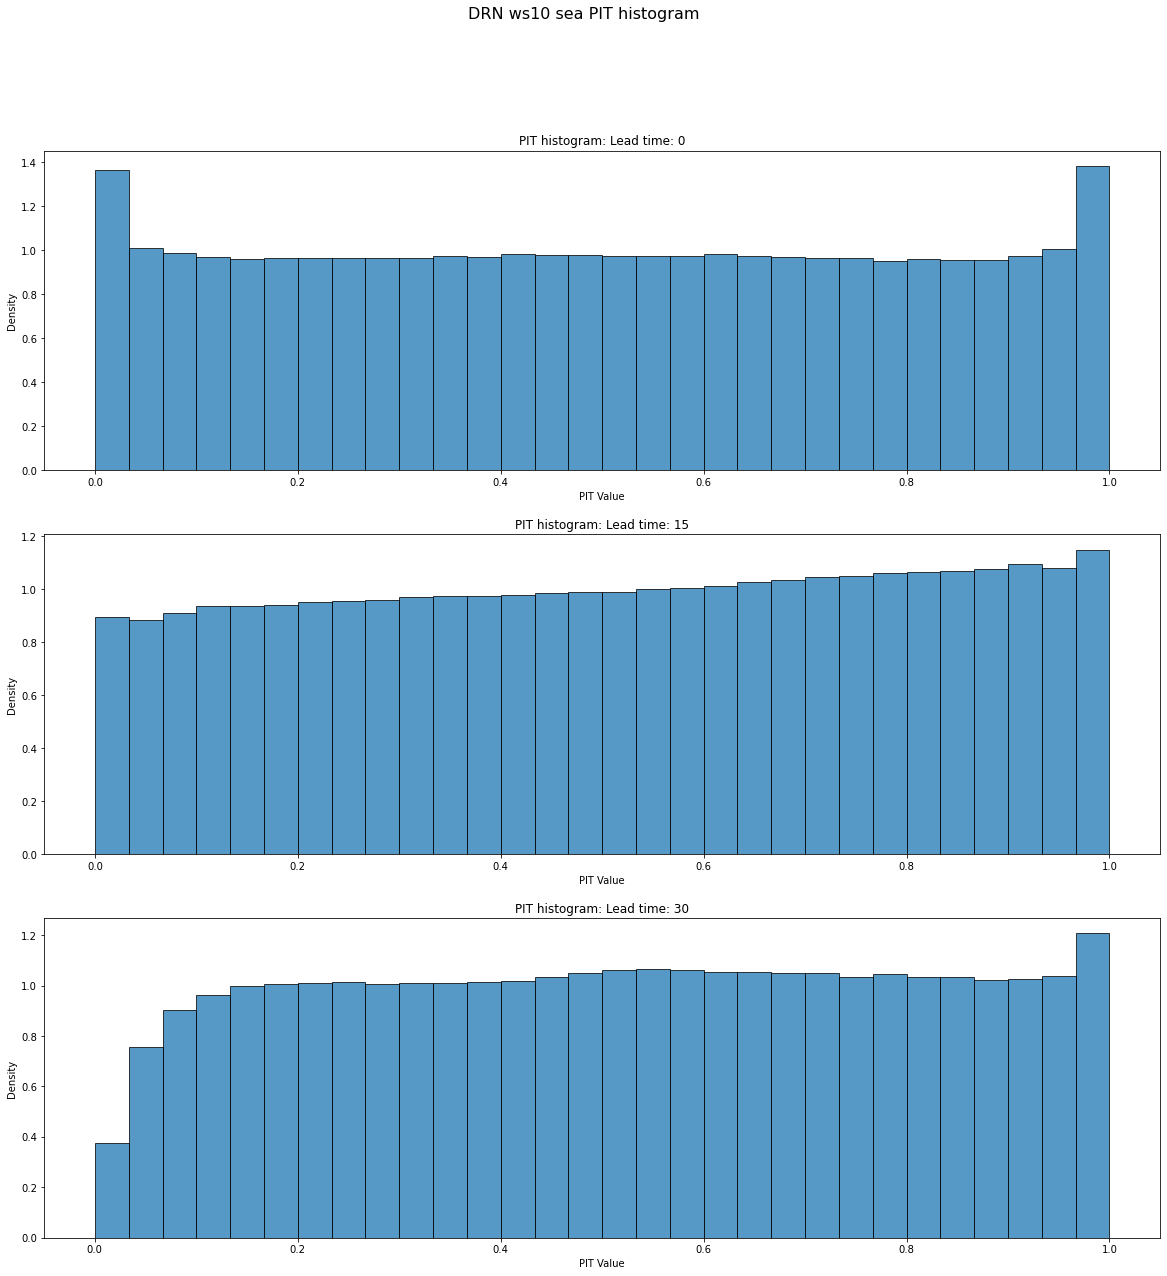

<IPython.core.display.Javascript object>

In [204]:
plot_pit_histogram_land_sea(
    DRN_ws10_preds,
    ws10_ground_truth,
    0,
    num_bins=30,
    title="DRN ws10 sea PIT histogram",
)